In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from sklearn.metrics import precision_score, f1_score,recall_score,accuracy_score
!pip install torchsummary
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset,random_split,DataLoader,Subset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!mkdir output

# Custom Dataset preparation

In [3]:
class SlumDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.masks = os.listdir(mask_dir)

  def __len__(self):
    return len(self.masks)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.masks[index])

    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path), dtype = np.float32)
    mask = (mask//246.0)
    image = (image/255.0)


    if self.transform != None:
      augment = self.transform(image = image,mask = mask)
      image = augment['image']
      mask = augment['mask']

      if(image.shape[1:] != mask.shape):
        print("-------------- ---------------------------")
        print("!!!Warning!!!")
        print(image.shape[1:])
        print(mask.shape)

    return image,mask

In [4]:
def save_checkpoint(state,filename = "my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

# Get the training and validation Dataloaders

In [5]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    train_val,
    num_workers = 2,
    pin_memory = True,
):

  train_ds = SlumDataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  val_ds = SlumDataset(
      image_dir = val_dir,
      mask_dir = val_mask_dir,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False,
  )

  return train_loader, val_loader

# Saved the predicted images along with the original image

In [6]:
def save_predictions_as_imgs(loader,model,folder="saved_images/",device = "cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device = device)
    y = y.unsqueeze(1).to(device)

    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()

    torchvision.utils.save_image(preds,f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y,f"{folder}/{idx}.jpg")

  model.train()

In [8]:
import torch
import torch.nn as nn
from torchvision.models import densenet121


#no change in height and width 
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

#increases height and width by factor of 2 
def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )


class denseUnet(nn.Module):
    
    def __init__(self,encoder,pretrained=True, out_channels=1):
        super().__init__()

        self.encoder = densenet121(pretrained=True).features
        for param in self.encoder.parameters():
          param.requires_grad=False

        self.block1 = nn.Sequential(*self.encoder[:6])#h=32 channel=128
        self.block2 = nn.Sequential(*self.encoder[6:8])#h=16 channel=256
        self.block3 = nn.Sequential(*self.encoder[8:10])#h=8 channel=512

        self.bottleneck = nn.Sequential(*self.encoder[10:])#h=8 channel 1024
        self.conv_bottleneck = double_conv(1024, 1024)#h=8
        
        self.up_conv6=nn.ConvTranspose2d(1024,1024,kernel_size=2,stride=2,padding=0)
        self.conv6a=nn.Conv2d(1024,512,kernel_size=1,stride=1,padding=0)
        self.conv6 = double_conv(512 + 512, 512)#h=16
        
        self.up_conv7=nn.ConvTranspose2d(512,512,kernel_size=2,stride=2,padding=0)
        self.conv7a=nn.Conv2d(512,256,kernel_size=1,stride=1,padding=0)
        self.conv7 = double_conv(256 + 256, 256)#h=32
        
        self.up_conv8=nn.ConvTranspose2d(256,256,kernel_size=2,stride=2,padding=0)
        self.conv8a=nn.Conv2d(256,128,kernel_size=1,stride=1,padding=0)
        self.conv8 = double_conv(128 + 128, 128)#h=64
        self.up_conv9 = up_conv(128, 64)#h=128
        self.conv9 = double_conv(64, 64)#h=128
        self.up_conv10 = up_conv(64, 32)#h=256
        self.conv10 = double_conv(32, 32)#h=256
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)#h=256
        self.conv12=nn.BatchNorm2d(out_channels)
    def forward(self, x1):
        #x..h=256 channels=3
        block1 = self.block1(x1)#h=32 channel=128
        block2 = self.block2(block1)#h=16 c=256
        block3 = self.block3(block2)#h=8 c=512

        bottleneck = self.bottleneck(block3)#h=8 c=1024
        x = self.conv_bottleneck(bottleneck)#h=8 c=1024
        
        x = self.conv6a(x)#h=8 c=512
        if x.shape != block3.shape:
          x = TF.resize(x,size = block3.shape[2:])
        x = torch.cat([x, block3], dim=1)#h=8 c=1024        
        x = self.up_conv6(x)#h=16 c=1024
        x = self.conv6(x)#h=16 c=512

        x = self.conv7a(x)#h=16 c=256
        if x.shape != block2.shape:
          x = TF.resize(x,size = block2.shape[2:])
        x = torch.cat([x, block2], dim=1)#h=16 c=512
        x = self.up_conv7(x)#h=32 c=512
        x = self.conv7(x)#h=32 c=256

        x = self.conv8a(x)#h=32 c=128
        if x.shape != block1.shape:
          x = TF.resize(x,size = block1.shape[2:])
        x = torch.cat([x, block1], dim=1)#h=32 c=256
        x = self.up_conv8(x)#h=64 c=256
        x = self.conv8(x)#h=64 c=128

        x = self.up_conv9(x)#h=128 c=64
        x = self.conv9(x)#h=128 c=64

        x = self.up_conv10(x)#h=256 c=32
        x = self.conv10(x)#h=256 c=32

        x = self.conv11(x)
        return x


def dense_unet(output_dim: int=1, pretrained: bool=False):
    return denseUnet(densenet121, pretrained=pretrained, out_channels=output_dim)


# Implement Focal Loss using predefined BCEWithLogitsLoss

In [9]:
# Custom Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

# All the hyperparameters and dataset path

In [10]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from numpy import random

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Hyperparameters
LEARNING_RATE = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2
train_val = 0.8
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
train_valid = 0.8

PIN_MEMORY = True
LOAD_MODEL = True

TRAIN_IMG_DIR = '/kaggle/input/slumdata/updated_complete_data/train_img'
TRAIN_MASK_DIR = '/kaggle/input/slumdata/updated_complete_data/train_mask'
val_dir = '/kaggle/input/slumdata/updated_complete_data/val_img'
val_mask_dir = '/kaggle/input/slumdata/updated_complete_data/val_mask'
saved_folder = '/kaggle/working/'

# Training function

In [11]:
def train_fn(loader,model,optimizer,loss_fn,scaler,losses):
  loop = tqdm(loader)

  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device = device)
    targets = targets.float().unsqueeze(1).to(device = device)
    targ = targets

    # forward
    with torch.cuda.amp.autocast():
      predictions = torch.sigmoid(model(data))
      loss = loss_fn(predictions,targets)
        
    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())
    
    losses.append(loss.item())

In [12]:
train_transform = A.Compose(
    [
      A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
      A.RandomCrop(height = IMAGE_HEIGHT,width=IMAGE_WIDTH),
      A.Rotate(limit = 35,p=1.0),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0,0.0,0.0],
          std = [1.0,1.0,1.0],
          max_pixel_value = 1.0
      ),
      ToTensorV2(),
    ], is_check_shapes=False
  )

val_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
     A.RandomCrop(height = IMAGE_HEIGHT,width=IMAGE_WIDTH),
     A.Normalize(
      mean=[0.0,0.0,0.0],
      std = [1.0,1.0,1.0],
      max_pixel_value = 1.0
    ),
    ToTensorV2(),
  ], is_check_shapes=False
  )
    
train_loader,val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      val_dir,
      val_mask_dir,
      BATCH_SIZE,
      train_transform,
      val_transform,
      train_val,
      NUM_WORKERS,
      PIN_MEMORY,
  )

model = dense_unet().to("cuda" if torch.cuda.is_available() else "cpu")

optimizers = {'Adadelta': optim.Adadelta(model.parameters(), lr = LEARNING_RATE),
             'Adagrad': optim.Adagrad(model.parameters(), lr = LEARNING_RATE),
             'SGD': optim.SGD(model.parameters(), lr = LEARNING_RATE), 
             'RMSPROP': optim.RMSprop(model.parameters(), lr = LEARNING_RATE), 
             'Adam': optim.Adam(model.parameters(), lr = LEARNING_RATE),
             
            }

loss_functions = {
    'Focal': FocalLoss(),
    'Hinge': nn.HingeEmbeddingLoss(),
    'BCE': nn.BCEWithLogitsLoss(),
    'MSE': nn.MSELoss(),
}

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 80.2MB/s]


100%|██████████| 178/178 [01:43<00:00,  1.71it/s, loss=0.305]


Adadelta is done


100%|██████████| 178/178 [01:43<00:00,  1.72it/s, loss=0.193]


Adagrad is done


100%|██████████| 178/178 [01:45<00:00,  1.69it/s, loss=0.226]


SGD is done


100%|██████████| 178/178 [01:45<00:00,  1.69it/s, loss=0.156]


RMSPROP is done


100%|██████████| 178/178 [01:46<00:00,  1.67it/s, loss=0.151]


Adam is done
Focal is done


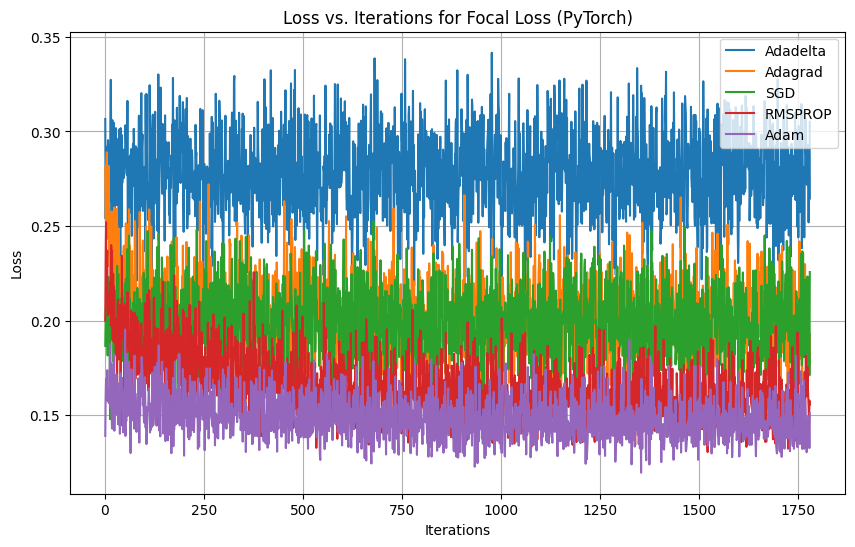

100%|██████████| 178/178 [01:45<00:00,  1.69it/s, loss=0.936]


Adadelta is done


100%|██████████| 178/178 [01:46<00:00,  1.67it/s, loss=0.938]


Adagrad is done


100%|██████████| 178/178 [01:46<00:00,  1.67it/s, loss=0.95]


SGD is done


100%|██████████| 178/178 [01:44<00:00,  1.70it/s, loss=0.871]


RMSPROP is done


100%|██████████| 178/178 [01:45<00:00,  1.69it/s, loss=0.705]


Adam is done
Hinge is done


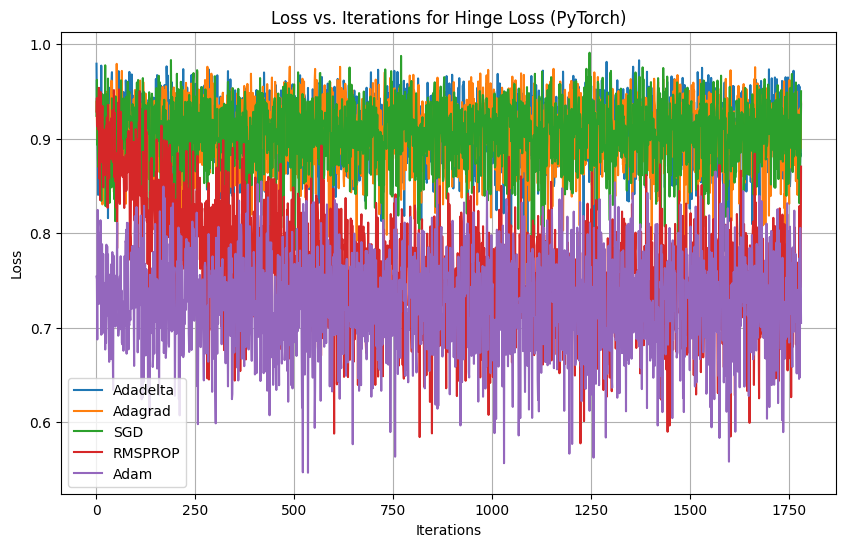

100%|██████████| 178/178 [01:47<00:00,  1.65it/s, loss=0.806]


Adadelta is done


100%|██████████| 178/178 [01:48<00:00,  1.65it/s, loss=0.792]


Adagrad is done


100%|██████████| 178/178 [01:46<00:00,  1.67it/s, loss=0.805]


SGD is done


100%|██████████| 178/178 [01:47<00:00,  1.66it/s, loss=0.801]


RMSPROP is done


100%|██████████| 178/178 [01:46<00:00,  1.67it/s, loss=0.767]


Adam is done
BCE is done


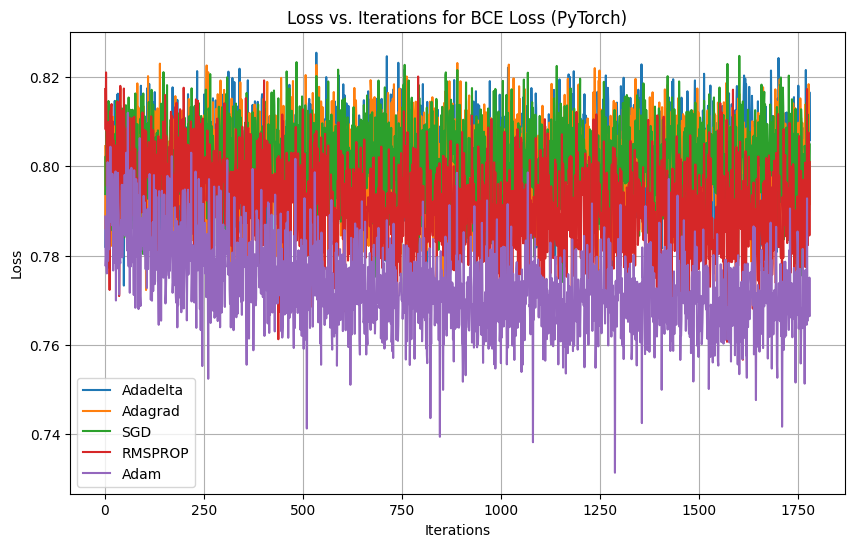

100%|██████████| 178/178 [01:46<00:00,  1.66it/s, loss=0.339]


Adadelta is done


100%|██████████| 178/178 [01:49<00:00,  1.63it/s, loss=0.528]


Adagrad is done


100%|██████████| 178/178 [01:46<00:00,  1.67it/s, loss=0.312]


SGD is done


100%|██████████| 178/178 [01:47<00:00,  1.66it/s, loss=0.49]


RMSPROP is done


100%|██████████| 178/178 [01:47<00:00,  1.65it/s, loss=0.443]


Adam is done
MSE is done


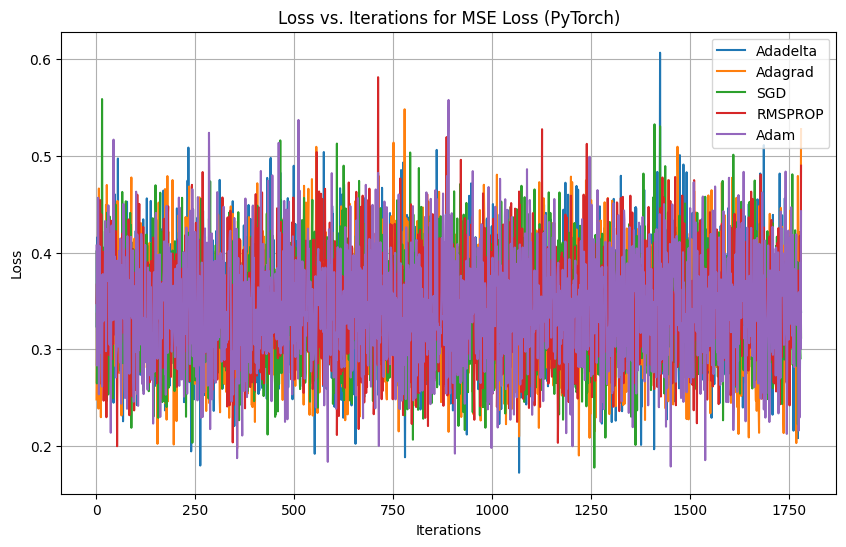

In [13]:
results = {}
for loss_name , loss_function in loss_functions.items():
    plt.figure(figsize=(10, 6))
    loss_history = {}
    for optimizer_name,optimizer in optimizers.items():
        model = model
        optimizer = optimizer
        scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
        scaler = torch.cuda.amp.GradScaler()
        losses = []
        for epoch in range(NUM_EPOCHS):
            train_fn(train_loader,model,optimizer,loss_function,scaler,losses)
            scheduler.step()
        
        loss_history[optimizer_name] = losses
        print(f"{optimizer_name} is done")
        plt.plot(range(1, len(losses)+1), losses, label=optimizer_name)
    print(f"{loss_name} is done")
    results[loss_name] = loss_history
    plt.title(f'Loss vs. Iterations for {loss_name} Loss (PyTorch)')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()